This notebook aims to extract critically ill patients with trauma from MIMIC III v1.4 Dataset

**Notes**:

This notebook assumes that you have access to MIMIC-III on Google BigQuery. If you're not sure if you do, or would like to apply for access, head over to the [MIMIC-III access page](https://colab.research.google.com/drive/1eFsiT1EtyUKtDetWUE9SvVCYay9OqJ88?usp=sharing) or the `notebooks/MIMIC-III access page` in the GitHub project for instructions.




# Set Up

## Mount Google Drive
Considering that the overall process may take a long time and Colab execution may be interrupted, we highly recommend mounting your Google Drive to Colab to save intermediate process data.

In [31]:
from google.colab import drive
drive.mount('/content/drive') #give access to Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Clone GitHub repo

To clone **private** GitHub repo

Use this section to load the repository before the paper is published. This private model is designed for the **testing** and **reviewing** process. To access the repository, you need to request key pairs by emailing the authors at jinyin@uw.edu or juhuah@uw.edu. Once the work is accepted and published, all the data and code will be made publicly available to all researchers.

Before running the following code:

1. Request the private code.
2. Update to your drive.
3. Update the **PATH variable** to your own drive path.
4. The following code will copy the key files to /root/.ssh.
5. Clone your repo

In [28]:
# To clone private GitHub repo
BASE_PATH = "/content/drive/MyDrive/PTSM_Private_Testing" # Remember to update this variable to your own path
!mkdir -p ~/.ssh  # Create the .ssh directory if it doesn't exis
!cp {BASE_PATH}/id_rsa* ~/.ssh/ #copy all id_rsa files from the specified path to /root/.ssh/
!ssh-keyscan github.com >> ~/.ssh/known_hosts  # Add GitHub's SSH key to the list of known hosts

# Change to the specified path and clone the repository
%cd {BASE_PATH}
!git clone git@github.com:bettyJin/Post_Traumatic_Sepsis_MIMICIII.git
%cd {BASE_PATH}/Post_Traumatic_Sepsis_MIMICIII/
!ls

# github.com:22 SSH-2.0-babeld-64443082
# github.com:22 SSH-2.0-babeld-64443082
# github.com:22 SSH-2.0-babeld-64443082
# github.com:22 SSH-2.0-babeld-6d1fc4bc
# github.com:22 SSH-2.0-babeld-64443082
/content/drive/MyDrive/PTSM_Private_Testing
fatal: destination path 'Post_Traumatic_Sepsis_MIMICIII' already exists and is not an empty directory.
/content/drive/MyDrive/PTSM_Private_Testing/Post_Traumatic_Sepsis_MIMICIII
data	 MaybeLater  OldDraft	requirements.txt  setup.py  supplementary
LICENSE  notebooks   README.md	scripts		  src


## import libraries

In [4]:
# Import libraries
import os
# import gzip # for load .csv.gz file #for load loacal dataset
import re   # the regular expressions module

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import date

In [8]:
%cd {BASE_PATH}/Post_Traumatic_Sepsis_MIMICIII
from src.data import data_utils, sql2df, data_fetcher

# # Initialize the ProjectPaths object
from src import path_manager
project_path_obj = path_manager.ProjectPaths(f'%s/Post_Traumatic_Sepsis_MIMICIII'%BASE_PATH)

# set environment variables of BigQuery
PROJECT_ID = 'sepsis-mimic3' # SET YOUR PROJECT ID

# # testing for big quene acccess
# data_utils.run_query("""
#           -- total number of hospital admission IDs in MIMIC III
#           SELECT COUNT(DISTINCT HADM_ID)
#           FROM `physionet-data.mimiciii_clinical.admissions`
#            """
#         , PROJECT_ID)

/content/drive/MyDrive/PTSM_Private_Testing/Post_Traumatic_Sepsis_MIMICIII


# ICD9 CODE Selection



In [10]:
# Load HMC's list of traumatic injury E-codes.
ICD9Code_file_path = os.path.join(project_path_obj.get_supplementary_file("ICD_Nonpoisoning_Cause_Matrix.xlsx"))
print(ICD9Code_file_path)
df_hmc_e = pd.read_excel(ICD9Code_file_path, sheet_name="Ecodes ICD 9")
# Reformat the codes to be consistent with MIMIC's format.
df_hmc_e["Ecode"] = df_hmc_e["Ecode"].apply(lambda x: "E" + re.sub(r'\W+', '', str(x)))
Ecodes = df_hmc_e["Ecode"].unique()
print(Ecodes.shape)
print(Ecodes)

/content/drive/MyDrive/PTSM_Private_Testing/Post_Traumatic_Sepsis_MIMICIII/supplementary/ICD_Nonpoisoning_Cause_Matrix.xlsx
(740,)
['E8000' 'E8001' 'E8002' 'E8003' 'E8008' 'E8009' 'E8010' 'E8011' 'E8012'
 'E8013' 'E8018' 'E8019' 'E8020' 'E8021' 'E8022' 'E8023' 'E8028' 'E8029'
 'E8030' 'E8031' 'E8032' 'E8033' 'E8038' 'E8039' 'E8040' 'E8041' 'E8042'
 'E8043' 'E8048' 'E8049' 'E8050' 'E8051' 'E8052' 'E8053' 'E8058' 'E8059'
 'E8060' 'E8061' 'E8062' 'E8063' 'E8068' 'E8069' 'E8070' 'E8071' 'E8072'
 'E8073' 'E8078' 'E8079' 'E8100' 'E8101' 'E8102' 'E8103' 'E8104' 'E8105'
 'E8106' 'E8107' 'E8108' 'E8109' 'E8110' 'E8111' 'E8112' 'E8113' 'E8114'
 'E8115' 'E8116' 'E8117' 'E8118' 'E8119' 'E8120' 'E8121' 'E8122' 'E8123'
 'E8124' 'E8125' 'E8126' 'E8127' 'E8128' 'E8129' 'E8130' 'E8131' 'E8132'
 'E8133' 'E8134' 'E8135' 'E8136' 'E8137' 'E8138' 'E8139' 'E8140' 'E8141'
 'E8142' 'E8143' 'E8144' 'E8145' 'E8146' 'E8147' 'E8148' 'E8149' 'E8150'
 'E8151' 'E8152' 'E8153' 'E8154' 'E8155' 'E8156' 'E8157' 'E8158' '

In [10]:
def select_ICDcode_df(project_id):
	'''
    Select trauma patients according to E-codes of ICD9_CODE
	'''
	# HMC's list of traumatic injury E-codes.
  # Detail saved at "ReferenceFiles/ICD_Nonpoisoning_Cause_Matrix.xlsx"
	Ecodes = np.array(
    ['E8000', 'E8001', 'E8002', 'E8003', 'E8008', 'E8009', 'E8010',
       'E8011', 'E8012', 'E8013', 'E8018', 'E8019', 'E8020', 'E8021',
       'E8022', 'E8023', 'E8028', 'E8029', 'E8030', 'E8031', 'E8032',
       'E8033', 'E8038', 'E8039', 'E8040', 'E8041', 'E8042', 'E8043',
       'E8048', 'E8049', 'E8050', 'E8051', 'E8052', 'E8053', 'E8058',
       'E8059', 'E8060', 'E8061', 'E8062', 'E8063', 'E8068', 'E8069',
       'E8070', 'E8071', 'E8072', 'E8073', 'E8078', 'E8079', 'E8100',
       'E8101', 'E8102', 'E8103', 'E8104', 'E8105', 'E8106', 'E8107',
       'E8108', 'E8109', 'E8110', 'E8111', 'E8112', 'E8113', 'E8114',
       'E8115', 'E8116', 'E8117', 'E8118', 'E8119', 'E8120', 'E8121',
       'E8122', 'E8123', 'E8124', 'E8125', 'E8126', 'E8127', 'E8128',
       'E8129', 'E8130', 'E8131', 'E8132', 'E8133', 'E8134', 'E8135',
       'E8136', 'E8137', 'E8138', 'E8139', 'E8140', 'E8141', 'E8142',
       'E8143', 'E8144', 'E8145', 'E8146', 'E8147', 'E8148', 'E8149',
       'E8150', 'E8151', 'E8152', 'E8153', 'E8154', 'E8155', 'E8156',
       'E8157', 'E8158', 'E8159', 'E8160', 'E8161', 'E8162', 'E8163',
       'E8164', 'E8165', 'E8166', 'E8167', 'E8168', 'E8169', 'E8170',
       'E8171', 'E8172', 'E8173', 'E8174', 'E8175', 'E8176', 'E8177',
       'E8178', 'E8179', 'E8180', 'E8181', 'E8182', 'E8183', 'E8184',
       'E8185', 'E8186', 'E8187', 'E8188', 'E8189', 'E8190', 'E8191',
       'E8192', 'E8193', 'E8194', 'E8195', 'E8196', 'E8197', 'E8198',
       'E8199', 'E8200', 'E8201', 'E8202', 'E8203', 'E8204', 'E8205',
       'E8206', 'E8207', 'E8208', 'E8209', 'E8210', 'E8211', 'E8212',
       'E8213', 'E8214', 'E8215', 'E8216', 'E8217', 'E8218', 'E8219',
       'E8220', 'E8221', 'E8222', 'E8223', 'E8224', 'E8225', 'E8226',
       'E8227', 'E8228', 'E8229', 'E8230', 'E8231', 'E8232', 'E8233',
       'E8234', 'E8235', 'E8236', 'E8237', 'E8238', 'E8239', 'E8240',
       'E8241', 'E8242', 'E8243', 'E8244', 'E8245', 'E8246', 'E8247',
       'E8248', 'E8249', 'E8250', 'E8251', 'E8252', 'E8253', 'E8254',
       'E8255', 'E8256', 'E8257', 'E8258', 'E8259', 'E8260', 'E8261',
       'E8262', 'E8263', 'E8264', 'E8268', 'E8269', 'E8270', 'E8272',
       'E8273', 'E8274', 'E8278', 'E8279', 'E8280', 'E8282', 'E8284',
       'E8288', 'E8289', 'E8290', 'E8294', 'E8298', 'E8299', 'E8300',
       'E8301', 'E8302', 'E8303', 'E8304', 'E8305', 'E8306', 'E8307',
       'E8308', 'E8309', 'E8310', 'E8311', 'E8312', 'E8313', 'E8314',
       'E8315', 'E8316', 'E8317', 'E8318', 'E8319', 'E8320', 'E8321',
       'E8322', 'E8323', 'E8324', 'E8325', 'E8326', 'E8327', 'E8328',
       'E8329', 'E8330', 'E8331', 'E8332', 'E8333', 'E8334', 'E8335',
       'E8336', 'E8337', 'E8338', 'E8339', 'E8340', 'E8341', 'E8342',
       'E8343', 'E8344', 'E8345', 'E8346', 'E8347', 'E8348', 'E8349',
       'E8350', 'E8351', 'E8352', 'E8353', 'E8354', 'E8355', 'E8356',
       'E8357', 'E8358', 'E8359', 'E8360', 'E8361', 'E8362', 'E8363',
       'E8364', 'E8365', 'E8366', 'E8367', 'E8368', 'E8369', 'E8370',
       'E8371', 'E8372', 'E8373', 'E8374', 'E8375', 'E8376', 'E8377',
       'E8378', 'E8379', 'E8380', 'E8381', 'E8382', 'E8383', 'E8384',
       'E8385', 'E8386', 'E8387', 'E8388', 'E8389', 'E8400', 'E8401',
       'E8402', 'E8403', 'E8404', 'E8405', 'E8406', 'E8407', 'E8408',
       'E8409', 'E8410', 'E8411', 'E8412', 'E8413', 'E8414', 'E8415',
       'E8416', 'E8417', 'E8418', 'E8419', 'E8426', 'E8427', 'E8428',
       'E8429', 'E8430', 'E8431', 'E8432', 'E8433', 'E8434', 'E8435',
       'E8436', 'E8437', 'E8438', 'E8439', 'E8440', 'E8441', 'E8442',
       'E8443', 'E8444', 'E8445', 'E8446', 'E8447', 'E8448', 'E8449',
       'E8450', 'E8458', 'E8459', 'E8460', 'E8470', 'E8480', 'E8800',
       'E8801', 'E8809', 'E8810', 'E8811', 'E8820', 'E8830', 'E8831',
       'E8832', 'E8839', 'E8840', 'E8841', 'E8842', 'E8843', 'E8844',
       'E8845', 'E8846', 'E8849', 'E8850', 'E8851', 'E8852', 'E8853',
       'E8854', 'E8859', 'E8860', 'E8869', 'E8870', 'E8880', 'E8881',
       'E8888', 'E8889', 'E8900', 'E8901', 'E8902', 'E8903', 'E8908',
       'E8909', 'E8910', 'E8911', 'E8912', 'E8913', 'E8918', 'E8919',
       'E8920', 'E8930', 'E8931', 'E8932', 'E8938', 'E8939', 'E8940',
       'E8950', 'E8960', 'E8970', 'E8980', 'E8981', 'E8990', 'E9000',
       'E9001', 'E9009', 'E9010', 'E9011', 'E9018', 'E9019', 'E9020',
       'E9021', 'E9022', 'E9028', 'E9029', 'E9030', 'E9040', 'E9041',
       'E9042', 'E9043', 'E9049', 'E9050', 'E9051', 'E9052', 'E9053',
       'E9054', 'E9055', 'E9056', 'E9057', 'E9060', 'E9061', 'E9062',
       'E9063', 'E9064', 'E9065', 'E9068', 'E9069', 'E9070', 'E9080',
       'E9081', 'E9082', 'E9083', 'E9084', 'E9088', 'E9089', 'E9090',
       'E9091', 'E9092', 'E9093', 'E9094', 'E9098', 'E9099', 'E9100',
       'E9101', 'E9102', 'E9103', 'E9104', 'E9108', 'E9109', 'E9110',
       'E9120', 'E9130', 'E9131', 'E9132', 'E9133', 'E9138', 'E9139',
       'E9140', 'E9150', 'E9160', 'E9170', 'E9171', 'E9172', 'E9173',
       'E9174', 'E9175', 'E9176', 'E9177', 'E9178', 'E9179', 'E9180',
       'E9190', 'E9191', 'E9192', 'E9193', 'E9194', 'E9195', 'E9196',
       'E9197', 'E9198', 'E9199', 'E9200', 'E9201', 'E9202', 'E9203',
       'E9204', 'E9205', 'E9208', 'E9209', 'E9210', 'E9211', 'E9218',
       'E9219', 'E9220', 'E9221', 'E9222', 'E9223', 'E9224', 'E9225',
       'E9228', 'E9229', 'E9230', 'E9231', 'E9232', 'E9238', 'E9239',
       'E9240', 'E9241', 'E9242', 'E9248', 'E9249', 'E9250', 'E9251',
       'E9252', 'E9258', 'E9259', 'E9270', 'E9271', 'E9272', 'E9273',
       'E9274', 'E9278', 'E9279', 'E9280', 'E9281', 'E9282', 'E9283',
       'E9284', 'E9285', 'E9286', 'E9287', 'E9288', 'E9289', 'E9507',
       'E9520', 'E9521', 'E9530', 'E9531', 'E9538', 'E9539', 'E9540',
       'E9550', 'E9551', 'E9552', 'E9553', 'E9554', 'E9555', 'E9556',
       'E9557', 'E9559', 'E9560', 'E9570', 'E9571', 'E9572', 'E9579',
       'E9580', 'E9581', 'E9582', 'E9583', 'E9584', 'E9585', 'E9586',
       'E9587', 'E9588', 'E9589', 'E9600', 'E9610', 'E9620', 'E9621',
       'E9622', 'E9630', 'E9640', 'E9650', 'E9651', 'E9652', 'E9653',
       'E9654', 'E9655', 'E9656', 'E9657', 'E9658', 'E9659', 'E9660',
       'E9670', 'E9671', 'E9672', 'E9673', 'E9674', 'E9675', 'E9676',
       'E9677', 'E9678', 'E9679', 'E9680', 'E9681', 'E9682', 'E9683',
       'E9684', 'E9685', 'E9686', 'E9687', 'E9688', 'E9689', 'E9700',
       'E9710', 'E9720', 'E9730', 'E9740', 'E9750', 'E9760', 'E9780',
       'E9790', 'E9791', 'E9792', 'E9793', 'E9794', 'E9795', 'E9796',
       'E9797', 'E9798', 'E9799', 'E9806', 'E9830', 'E9831', 'E9838',
       'E9839', 'E9840', 'E9850', 'E9851', 'E9852', 'E9853', 'E9854',
       'E9855', 'E9856', 'E9857', 'E9860', 'E9870', 'E9871', 'E9872',
       'E9879', 'E9880', 'E9881', 'E9882', 'E9883', 'E9884', 'E9885',
       'E9886', 'E9888', 'E9889', 'E9900', 'E9901', 'E9902', 'E9903',
       'E9909', 'E9910', 'E9911', 'E9912', 'E9913', 'E9914', 'E9915',
       'E9916', 'E9917', 'E9918', 'E9919', 'E9920', 'E9921', 'E9922',
       'E9923', 'E9928', 'E9929', 'E9930', 'E9931', 'E9932', 'E9933',
       'E9934', 'E9935', 'E9936', 'E9937', 'E9938', 'E9939', 'E9940',
       'E9941', 'E9942', 'E9943', 'E9948', 'E9949', 'E9950', 'E9951',
       'E9952', 'E9953', 'E9954', 'E9958', 'E9959', 'E9960', 'E9961',
       'E9968', 'E9969', 'E9970', 'E9971', 'E9972', 'E9973', 'E9978',
       'E9979', 'E9980', 'E9981', 'E9988', 'E9989'], dtype=object)


	# select all ICD diagnoses where ICD9_CODE is not NULL
	query =  """
	SELECT *
	FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
	WHERE ICD9_CODE IS NOT NULL;
	"""
	ICDDIAGNOSES_df = data_utils.run_query(query, project_id)

	# select "ICD9_CODE" starting with E
	trum_df = ICDDIAGNOSES_df[ICDDIAGNOSES_df['ICD9_CODE'].str.startswith('E')]
	trum_df.loc[:, "ICD9_CODE"] = trum_df.loc[:, "ICD9_CODE"].apply(lambda e: str(e)+"0" if len(str(e)) < 5 else e)

	# Select all E-code diagnoses.
	trum_df = trum_df[trum_df['ICD9_CODE'].isin(Ecodes)]

	return trum_df
# df = select_ICDcode_df(PROJECT_ID)
# print(df.shape)
# df.head()

# Demographics
------------------------------------------------------------------
Description: This query provides a useful set of information regarding patient
             ICU stays. The information is combined from the admissions, patients, and icustays tables. It includes age, length of stay, sequence, and expiry flags.
MIMIC version: MIMIC-III v1.4
A modified version of: https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iii/concepts/demographics/icustay_detail.sql
Modifications include:
  1. Duration result is expressed in hours instead of in days
------------------------------------------------------------------
This table includes:
*   Patient Info:
 >  'subject_id', 'gender', 'dod', 'ethnicity', 'ethnicity_grouped'
*   Hospital Admission Info:
 >  'hadm_id', 'admittime', 'dischtime', 'los_hospital_hours', 'admission_age', 'hospital_expire_flag' (0/1), 'hospstay_seq', 'first_hosp_stay' (T/F)
* ICUstay Info:
 > 'icustay_id', 'intime', 'outtime', 'los_icu_hours', 'icustay_seq', 'first_icu_stay' (T/F)

In [7]:
# from src.data import sql2df
# Check if the file exists
demog_path = project_path_obj.get_raw_data_file('demographics.csv')
if os.path.exists(demog_path):
    # Load the CSV file into a DataFrame
    demog_df = pd.read_csv(demog_path, index_col=0)
else:
    # Query demographics information by using BigQuery
    demog_df = sql2df.demog_sql2df(PROJECT_ID, saved_path=demog_path)
demog_df.head(5) #= demog_df[['subject_id', 'hadm_id', 'icustay_id','admission_age', 'los_hospital_hours']]

File saved at: /content/drive/MyDrive/PTSM_Private_Testing/Post_Traumatic_Sepsis_MIMICIII/data/raw/demographics.csv


,subject_id,hadm_id,icustay_id,gender,dod,admittime,dischtime,los_hospital_days,los_hospital_hours,admission_age,...,ethnicity_grouped,hospital_expire_flag,hospstay_seq,first_hosp_stay,intime,outtime,los_icu_days,los_icu_hours,icustay_seq,first_icu_stay
0,2,163353,243653,M,NaT,2138-07-17 19:04:00,2138-07-21 15:48:00,4,92,0,...,asian,0,1,True,2138-07-17 21:20:07,2138-07-17 23:32:21,0,2,1,True
1,3,145834,211552,M,2102-06-14,2101-10-20 19:08:00,2101-10-31 13:58:00,11,258,76,...,white,0,1,True,2101-10-20 19:10:11,2101-10-26 20:43:09,6,145,1,True
2,4,185777,294638,F,NaT,2191-03-16 00:28:00,2191-03-23 18:41:00,7,186,48,...,white,0,1,True,2191-03-16 00:29:31,2191-03-17 16:46:31,1,40,1,True
3,5,178980,214757,M,NaT,2103-02-02 04:31:00,2103-02-04 12:15:00,2,56,0,...,asian,0,1,True,2103-02-02 06:04:24,2103-02-02 08:06:00,0,2,1,True
4,6,107064,228232,F,NaT,2175-05-30 07:15:00,2175-06-15 16:00:00,16,393,66,...,white,0,1,True,2175-05-30 21:30:54,2175-06-03 13:39:54,4,88,1,True


# Ventilation

Based on source file: [ventilation_classification.sql](https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iii/concepts/durations/ventilation_classification.sql)


In [16]:
def ventilation_day_processed(project_id, vent_type=['MechVent'], saved_path=None):
  '''
  Identify the presence of mechanical ventilation
  - Based on source file: [ventilation_classification.sql](https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iii/concepts/durations/ventilation_classification.sql)

  Compute the number of days the patient (HADM_ID) was receiving ventilation events
  - Regardless of how many hours in that day the patient received ventilation

  Parameters:
    project_id: BigQuery MIMIC-III Project ID
    vent_type: A subset of 4 ventilation types ['MechVent', 'OxygenTherapy', 'Extubated', 'SelfExtubated'].
              This function only counts the ventilation types within this subset.
              By default, only 'MechVent' will be considered a qualifying ventilation event.
  '''
  # Identify the presence of a mechanical ventilation using settings
  vent_df = data_utils.run_query(
      """
      SELECT i.hadm_id, v.*
      FROM `physionet-data.mimiciii_derived.ventilation_classification` v
      JOIN `physionet-data.mimiciii_clinical.icustays` i
      ON v.ICUSTAY_ID = i.ICUSTAY_ID;
      """, project_id)

  # Select qualified ventilation event according to vent_type
  vent_df['sum'] = vent_df[vent_type].sum(axis=1)
  qualified_vent_df = vent_df[vent_df['sum']>0]
  numevent = qualified_vent_df.shape[0]
  # Get date
  qualified_vent_df['date_count'] = pd.to_datetime(qualified_vent_df['charttime']).dt.date
  vent_day_df = qualified_vent_df[['hadm_id', 'date_count']].drop_duplicates()
  # Count ventilation days: if a patient get ventilation (regaless of specific hours), then +1
  vent_day_count = vent_day_df.groupby('hadm_id').date_count.count().reset_index()
  if saved_path is not None:
    vent_day_count.to_csv(saved_path)
  return vent_day_count


In [8]:
from src.data.sql2df import ventilation_day_processed

# get ventilation day table
vent_path = project_path_obj.get_processed_data_file('MVday.csv')
if os.path.exists(vent_path):
    vent_df = pd.read_csv(vent_path, index_col=0)
else:
    vent_df = ventilation_day_processed(PROJECT_ID, vent_type=['MechVent'], saved_path=vent_path)
vent_df.shape

/content/drive/MyDrive/PTSM_Private_Testing/Post_Traumatic_Sepsis_MIMICIII/src/data/sql2df.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified_vent_df['date_count'] = pd.to_datetime(qualified_vent_df['charttime']).dt.date


(26761, 2)

In [ ]:
# If we count all 4 type of ventilation
# vent_day_count = ventilation_day_count(PROJECT_ID, vent_type=['MechVent','OxygenTherapy','Extubated','SelfExtubated'])
# # If we only count critical feature/variable: MechVent (i.e., mechanical ventilation)
# vent_day_count = ventilation_day_count(PROJECT_ID, vent_type=['MechVent'])

# Select Critically Ill Trauma Patients

In [23]:
from src.data.data_fetcher import get_demographics_data, get_ventilation_data

In [37]:
def trum_population_ids(project_path_obj, #Saved File Paths
                        project_id,       #Source File
                        vent_threshold=3,
                        is_report=False):
  """
  Trauma Population Selection Criteria:
    1. Select trauma patients according to E-codes of ICD9_CODE
    2. Age between [18, 89]
    3. Hospital stay duration between [48 hours, None)
    4. Ventilation days >= 3
       Ventilation days:
       vent_threshold:
          -> if None, then MV filter is not included
          -> or an int, the lower bound for MV filter.
          -> this boundary is experimental
          -> in Stern's paper, they use 3 as the threshold
             (Stern K, Qiu Q, Weykamp M, O’Keefe G, Brakenridge SC.
              Defining Posttraumatic Sepsis for Population-Level Research.
              JAMA Netw Open. 2023;6(1):e2251445. doi:10.1001/jamanetworkopen.2022.51445 )
  """
  # Get all patients' demographics
  demog_df = get_demographics_data(project_path_obj, project_id)
  demog_df = demog_df[['subject_id', 'hadm_id', 'icustay_id','admission_age', 'los_hospital_hours', 'los_hospital_days', 'hospital_expire_flag']]
  count_df = demog_df[['subject_id', 'hadm_id', 'icustay_id']].nunique().to_frame(name='TOTAL')

  # Selected accordind to E-code,
  # group by IDs and agg ICD9_CODE info, because we want unique IDs
  TRUM_df = select_ICDcode_df(project_id).groupby(['SUBJECT_ID', 'HADM_ID'])['ICD9_CODE'].agg(set).reset_index()
  TRUM_df = demog_df[demog_df['hadm_id'].isin(TRUM_df.HADM_ID)]

  # filter according to the age in range [18, 89]
  TRUM_df_age = TRUM_df[(TRUM_df.admission_age >= 18) & (TRUM_df.admission_age <= 89)]

  # filter according to the HADM duration in range [48h, NO upper bound)
  TRUM_df_los = TRUM_df_age[TRUM_df_age.los_hospital_hours >= 48]
  count_df['TRUM basic filter'] = TRUM_df_los[['subject_id', 'hadm_id', 'icustay_id']].nunique()

  # Select accoring to Ventilation Days
  if vent_threshold == None:
    trum_df = TRUM_df_los
  else:
    # get ventilation day table
    vent_day_count = get_ventilation_data(project_path_obj, project_id)
    #select accoring to Ventilation days >= vent_threshold(default is 3) for each patients
    TRUM_df_vent = TRUM_df_los.merge(vent_day_count, on='hadm_id', how='left')
    trum_vent_day_count = TRUM_df_vent[['hadm_id','date_count']].drop_duplicates()
    TRUM_df_vent = TRUM_df_vent[TRUM_df_vent['date_count'] >= vent_threshold]
    count_df['TRUM Vent filter'] = TRUM_df_vent[['subject_id', 'hadm_id', 'icustay_id']].nunique()
    trum_df = TRUM_df_vent

  # Statistics ###
  if is_report:
    display(count_df)
    print("MIMIC III includes %d hospital admission"%demog_df.hadm_id.nunique())
    print("After Truama selection (ICD-9): ", TRUM_df.hadm_id.nunique())
    print("After Age Filter: ", TRUM_df_age.hadm_id.nunique())
    TRUM_df_firstfewday = TRUM_df_age.loc[TRUM_df_age.los_hospital_hours<48, ['hadm_id', 'hospital_expire_flag']].drop_duplicates()
    TRUM_df_firstfewday_mortalitycount = TRUM_df_firstfewday.hospital_expire_flag.value_counts()
    print(f"After Hospital Length of Stay >= 48h Filter: %d"%(TRUM_df_los.hadm_id.nunique()))
    print(f"\t Hospital Length of Stay  < 48h: %d = %d(Died) + %d(Discharged Alive)"%(TRUM_df_firstfewday.shape[0],TRUM_df_firstfewday_mortalitycount[1], TRUM_df_firstfewday_mortalitycount[0]))
    if vent_threshold != None:
      num_NotIntubated = trum_vent_day_count.date_count.isna().sum()
      Intubated_less_thr = trum_vent_day_count[trum_vent_day_count.date_count<vent_threshold].shape[0]
      print('MV day filter out: \n\t%d(Not Intubated) + %d(Intubated < %d)'%(num_NotIntubated, Intubated_less_thr, vent_threshold))
    print("Final Cohort Size:", trum_df.hadm_id.nunique())

  return trum_df

In [38]:
# Default config: with MV day >=3 day filter
TRUM_df = trum_population_ids(project_path_obj, PROJECT_ID,
                              vent_threshold=3,
                              is_report=True)

,TOTAL,TRUM basic filter,TRUM Vent filter
subject_id,46428,4826,1551
hadm_id,57328,4977,1570
icustay_id,61051,5410,1828


MIMIC III includes 57328 hospital admission
After Truama selection (ICD-9):  6148
After Age Filter:  5651
After Hospital Length of Stay >= 48h Filter: 4977
	 Hospital Length of Stay  < 48h: 674 = 200(Died) + 474(Discharged Alive)
MV day fillter out: 
	2271(Not Intubated) + 1136(Intubated < 3)
Final Cohort Size: 1570


<Axes: >

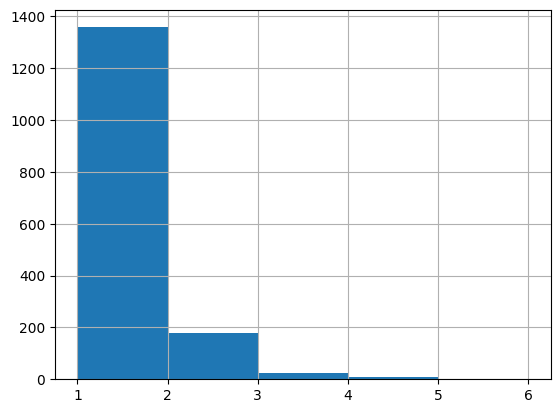

In [14]:
# One hospital admission may have multiple ICU stays
# Most hospital admissions only have one ICU stay
TRUM_df.groupby('hadm_id').icustay_id.nunique().hist(bins=[1, 2, 3, 4, 5, 6])

## Other Config

In [35]:
# with MV day >=3 day filter w/o Statistics Report
TRUM_df = trum_population_ids(project_path_obj, PROJECT_ID,
                              vent_threshold=3,
                              is_report=False)

In [39]:
# with out MV day filter
TRUM_df = trum_population_ids(project_path_obj, PROJECT_ID,
                              vent_threshold=None,
                              is_report=True)

,TOTAL,TRUM basic filter
subject_id,46428,4826
hadm_id,57328,4977
icustay_id,61051,5410


MIMIC III includes 57328 hospital admission
After Truama selection (ICD-9):  6148
After Age Filter:  5651
After Hospital Length of Stay >= 48h Filter: 4977
	 Hospital Length of Stay  < 48h: 674 = 200(Died) + 474(Discharged Alive)
Final Cohort Size: 4977


# Library-Based Cohort Extraction
This section shows how to use the function to achieve the same cohort extraction process in a more streamlined and reusable manner. The function is imported from a Python file, and the output is compared to ensure consistency with the previous section.

In [2]:
# BASE_PATH = "/content/drive/MyDrive/PTSM_Private_Testing" # Remember to update this variable to your own path
# %cd $BASE_PATH/Post_Traumatic_Sepsis_MIMICIII
# !ls

/content/drive/MyDrive/PTSM_Private_Testing/Post_Traumatic_Sepsis_MIMICIII
data	 MaybeLater  OldDraft	requirements.txt  setup.py  supplementary
LICENSE  notebooks   README.md	scripts		  src


In [4]:
# Initialize the ProjectPaths object
# with the full path to the Post_Traumatic_Sepsis_MIMICIII directory, where the base path is where the GitHub project was cloned
from src import path_manager
project_path_obj = path_manager.ProjectPaths(f'{BASE_PATH}/Post_Traumatic_Sepsis_MIMICIII')
# set environment variables of BigQuery
PROJECT_ID = 'sepsis-mimic3' # SET YOUR PROJECT ID

from scripts.cohort_extraction import cohort_ids
# Extract cohort IDs and generate a statistics report
trum_ids = cohort_ids(project_path_obj,    # Saved File Paths
                      PROJECT_ID,          # To query raw data
                      is_report=True       # Print statistics report
                      )

/content/drive/MyDrive/PTSM_Private_Testing/Post_Traumatic_Sepsis_MIMICIII/src/data/sql2df.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified_vent_df['date_count'] = pd.to_datetime(qualified_vent_df['charttime']).dt.date


Saved mechanical ventilation day at /content/drive/MyDrive/PTSM_Private_Testing/Post_Traumatic_Sepsis_MIMICIII/data/processed/MVday.csv


,TOTAL,TRUM basic filter,TRUM Vent filter
subject_id,46428,4826,1551
hadm_id,57328,4977,1570
icustay_id,61051,5410,1828


MIMIC III includes 57328 hospital admission
After Truama selection (ICD-9):  6148
After Age Filter:  5651
After Hospital Length of Stay >= 48h Filter: 4977
	 Hospital Length of Stay  < 48h: 674 = 200(Died) + 474(Discharged Alive)
MV day filter out:: 
	2271(Not Intubated) + 1136(Intubated < 3)
Final Cohort Size: 1570
